In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("../")

In [3]:
from data_processing.start_experiment import *
from data_processing.read_data import *
from data_processing.gaussian import *

In [366]:
import matplotlib.pyplot as plt
import numpy as np
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
import GPy
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity
import time
import random
from sklearn import tree
from sklearn.datasets import make_friedman2
from emukit.quadrature.methods import VanillaBayesianQuadrature
from emukit.quadrature.loop import VanillaBayesianQuadratureLoop
from emukit.core.initial_designs import RandomDesign
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, EntropySearch
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
import subprocess
from sklearn.gaussian_process import GaussianProcessRegressor
from skopt import gp_minimize

In [275]:
from emukit.core.interfaces import IModel, IDifferentiable

class SklearnGPModel(IModel,IDifferentiable):
    def __init__(self, sklearn_model):
        self.model = sklearn_model

    def predict(self, X):
        mean, std = self.model.predict(X, return_std=True)
        return mean[:, None], np.square(std)[:, None]

    def set_data(self, X: np.ndarray, Y: np.ndarray) -> None:
        self.model.fit(X, Y)

    def optimize(self, verbose: bool = False) -> None:
        # There is no separate optimization routine for sklearn models
        pass
    
    

    @property
    def X(self) -> np.ndarray:
        return self.model.X_train_

    @property
    def Y(self) -> np.ndarray:
        return self.model.y_train_



In [5]:
num_experiments = 100
parameter_list_small = ['gamma', 'gradnoise']
parameter_list =  ['season_duration', 'gamma', 'mut_rate', 'T', 'target_area', 'gradnoise']
parameter_space_small = ParameterSpace([
                                DiscreteParameter('gamma',list(range(0,25))),
                                ContinuousParameter('gradnoise',0.25,0.99)])
parameter_space = ParameterSpace([DiscreteParameter('season_duration',list(range(100,1001,10))), 
                                 DiscreteParameter('gamma',list(range(0,25))), 
                                 ContinuousParameter('mut_rate',0,0.5),
                                 ContinuousParameter('T',1,100),
                                 DiscreteParameter('target_area',list(range(1,101))),
                                 ContinuousParameter('gradnoise',0.25,0.99)])

In [6]:
file_names = ["latin/latin_{}.par".format(i) for i in range(num_experiments)]
data_files = ["latin/data_cellcount_{}.txt".format(i) for i in range(num_experiments)]

In [7]:
file_names_small = ["gradient_latin/latin_{}.par".format(i) for i in range(num_experiments)]
data_files_small = ["gradient_latin/data_cellcount_{}.txt".format(i) for i in range(num_experiments)]

In [10]:
def extract_data(file_names,data_files,parameter_list):
    X = get_parameter_array(file_names,parameter_list)

    # Some files have no data; don't get those
    unrun_files = get_no_data(data_files) 
    X_no_data = X[unrun_files,:]

    X = np.delete(X,unrun_files,axis=0)
    
    all_data = [read_data(file_name) for i,file_name in enumerate(data_files) if i not in unrun_files]
    Y = get_rewards(data_files,lambda s: len(s))
    
    run_to_completion = Y>5000
    X_full, Y_full = X[run_to_completion.flatten(),:], Y[run_to_completion.flatten()]
    X_full[0,:] = np.lcm(X_full[0,:].astype(int),25)
    
    data_full = [data for i,data in enumerate(all_data) if run_to_completion[i,0] == True]
    num_blob_data = np.array([[num_blobs_cells(data,j) for j in range(0,50000,1000)] for data in data_full])
    
    return X_full, num_blob_data

In [21]:
X, num_blob_data = extract_data(file_names,data_files,parameter_list)

In [12]:
X_small, num_blob_data_small = extract_data(file_names_small,data_files_small,parameter_list_small)

In [290]:
X_small = X_small[1:,:]
num_blob_data_small =  num_blob_data_small[1:,:]

In [ ]:
# file_names = ["latin/latin_{}.par".format(i) for i in range(num_experiments)]
# data_files = ["latin/data_cellcount_{}.txt".format(i) for i in range(num_experiments)]

In [7]:
X = get_parameter_array(file_names,parameter_list)

# Some files have no data; don't get those
unrun_files = get_no_data(data_files) 
X_no_data = X[unrun_files,:]

X = np.delete(X,unrun_files,axis=0)

In [8]:
all_data = [read_data(file_name) for i,file_name in enumerate(data_files) if i not in unrun_files]

In [10]:
Y = get_rewards(data_files,lambda s: len(s))

In [11]:
run_to_completion = Y>5000

In [12]:
X_full, Y_full = X[run_to_completion.flatten(),:], Y[run_to_completion.flatten()]

In [13]:
X_full[0,:] = np.lcm(X_full[0,:].astype(int),25)

In [14]:
data_full = [data for i,data in enumerate(all_data) if run_to_completion[i,0] == True]

In [15]:
num_blob_data = [[num_blobs_cells(data,j) for j in range(0,50000,1000)] for data in data_full]

# 1. Decision Tree; what are the most important values

## 1a. Decision Tree on the whole Latin Dataset

In [22]:
X_tree = X
Y_tree = num_blob_data[:,0].reshape(len(num_blob_data),1)

In [23]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_tree,Y_tree)

DecisionTreeClassifier()

In [24]:
clf.feature_importances_

array([0.05758157, 0.58733205, 0.        , 0.03598848, 0.17034549,
       0.1487524 ])

In [25]:
Y_tree_rounded = np.digitize(Y_tree,[0,20,100])
clf = tree.DecisionTreeClassifier()
clf.fit(X_tree,Y_tree_rounded)

DecisionTreeClassifier()

[Text(334.8, 543.6, 'X[1] <= 5.5\ngini = 0.353\nsamples = 75\nvalue = [4, 12, 59]'),
 Text(167.4, 326.16, 'X[4] <= 51.0\ngini = 0.32\nsamples = 15\nvalue = [3, 12, 0]'),
 Text(83.7, 108.72000000000003, 'gini = 0.0\nsamples = 3\nvalue = [3, 0, 0]'),
 Text(251.10000000000002, 108.72000000000003, 'gini = 0.0\nsamples = 12\nvalue = [0, 12, 0]'),
 Text(502.20000000000005, 326.16, 'X[1] <= 62.0\ngini = 0.033\nsamples = 60\nvalue = [1, 0, 59]'),
 Text(418.5, 108.72000000000003, 'gini = 0.0\nsamples = 59\nvalue = [0, 0, 59]'),
 Text(585.9, 108.72000000000003, 'gini = 0.0\nsamples = 1\nvalue = [1, 0, 0]')]

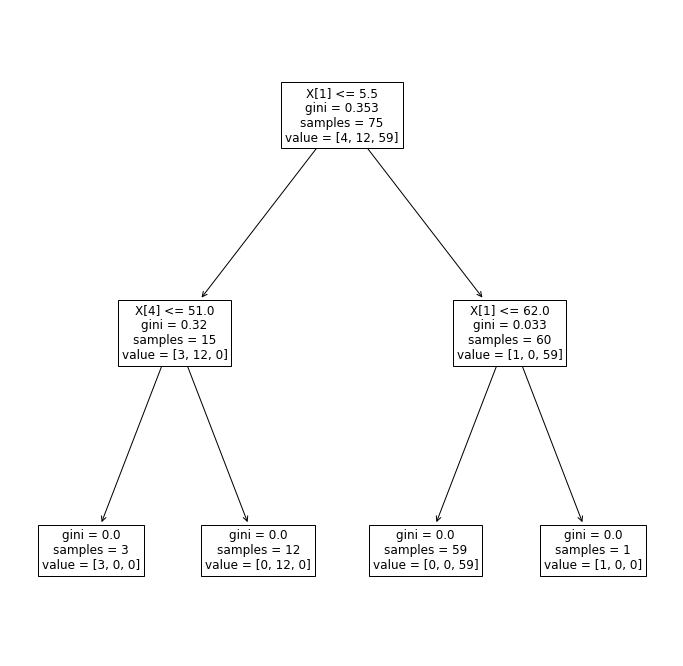

In [26]:
plt.figure(figsize=(12,12))
tree.plot_tree(clf,fontsize=12)

In [27]:
Y_tree = num_blob_data[:,-1].reshape(len(num_blob_data),1)
Y_tree_rounded = np.digitize(Y_tree,[50])
clf = tree.DecisionTreeClassifier()
clf.fit(X_tree,Y_tree_rounded)

DecisionTreeClassifier()

In [28]:
clf.feature_importances_

array([0.14338338, 0.05569479, 0.21400484, 0.18497223, 0.37153413,
       0.03041062])

[Text(313.875, 611.5500000000001, 'X[3] <= 54.46\ngini = 0.365\nsamples = 75\nvalue = [18, 57]'),
 Text(167.4, 530.01, 'X[2] <= 0.145\ngini = 0.48\nsamples = 40\nvalue = [16, 24]'),
 Text(125.55000000000001, 448.47, 'gini = 0.0\nsamples = 11\nvalue = [0, 11]'),
 Text(209.25, 448.47, 'X[4] <= 50.0\ngini = 0.495\nsamples = 29\nvalue = [16, 13]'),
 Text(167.4, 366.93, 'gini = 0.0\nsamples = 8\nvalue = [0, 8]'),
 Text(251.10000000000002, 366.93, 'X[0] <= 705.0\ngini = 0.363\nsamples = 21\nvalue = [16, 5]'),
 Text(167.4, 285.39000000000004, 'X[3] <= 22.78\ngini = 0.208\nsamples = 17\nvalue = [15, 2]'),
 Text(125.55000000000001, 203.85000000000002, 'X[1] <= 11.5\ngini = 0.408\nsamples = 7\nvalue = [5, 2]'),
 Text(83.7, 122.31000000000006, 'X[4] <= 68.0\ngini = 0.444\nsamples = 3\nvalue = [1, 2]'),
 Text(41.85, 40.76999999999998, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(125.55000000000001, 40.76999999999998, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(167.4, 122.31000000000006,

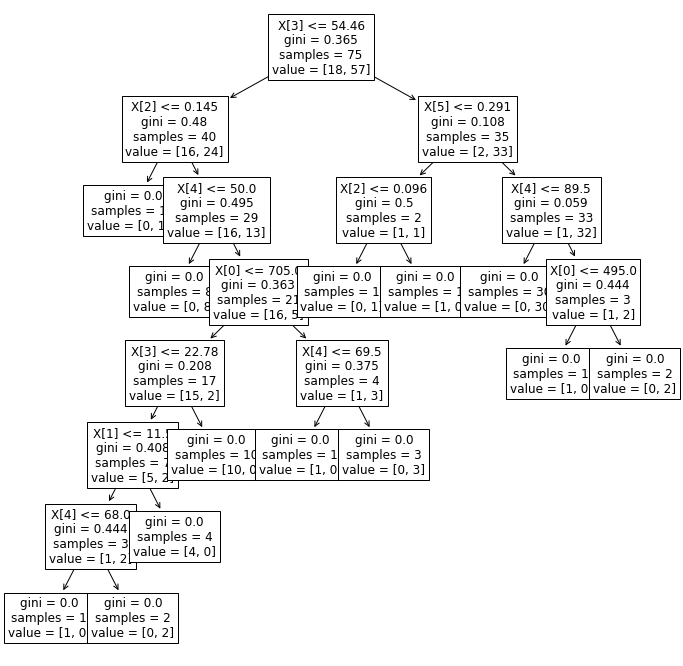

In [29]:
plt.figure(figsize=(12,12))
tree.plot_tree(clf,fontsize=12)

Initial multicellularity is largely based on cell-based parameters, particularly the gamma parameter, and the cell size, both of which dictate how close together they initial huddle together. However, after time persists, the dominant factors in how multicellularity persists are the environmental factors. Temperature is the top factor in the decision tree; if the temperature is large, then particles are too "jumpy" to stick together, and so large temperature lead to large numbers of blobs. Cell factors still play a role, such as having a large enough cell size to encourage contact, and a large enough mutation rate that adhesion is encouraged

## 1b. Decision Tree on the smaller Latin Dataset

In [32]:
X_tree = X_small
Y_tree = num_blob_data_small[:,0].reshape(len(num_blob_data_small),1)

In [33]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_tree,Y_tree)

DecisionTreeClassifier()

In [34]:
clf.feature_importances_

array([0.64772663, 0.35227337])

In [35]:
Y_tree_rounded = np.digitize(Y_tree,[0,20,100])
clf = tree.DecisionTreeClassifier()
clf.fit(X_tree,Y_tree_rounded)

DecisionTreeClassifier()

[Text(401.76000000000005, 543.6, 'X[0] <= 5.5\ngini = 0.261\nsamples = 88\nvalue = [4, 9, 75]'),
 Text(267.84000000000003, 326.16, 'X[0] <= 4.5\ngini = 0.426\nsamples = 13\nvalue = [4, 9, 0]'),
 Text(133.92000000000002, 108.72000000000003, 'gini = 0.0\nsamples = 9\nvalue = [0, 9, 0]'),
 Text(401.76000000000005, 108.72000000000003, 'gini = 0.0\nsamples = 4\nvalue = [4, 0, 0]'),
 Text(535.6800000000001, 326.16, 'gini = 0.0\nsamples = 75\nvalue = [0, 0, 75]')]

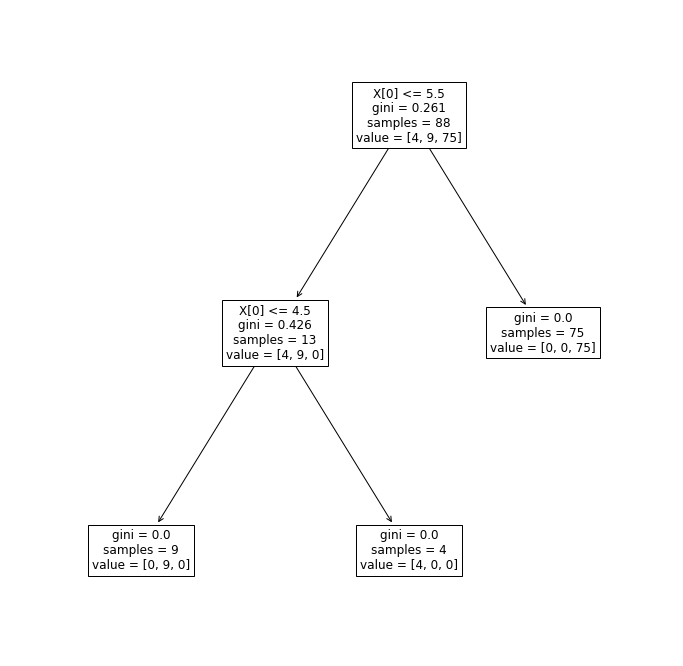

In [36]:
plt.figure(figsize=(12,12))
tree.plot_tree(clf,fontsize=12)

In [37]:
Y_tree = num_blob_data_small[:,-1].reshape(len(num_blob_data_small),1)
Y_tree_rounded = np.digitize(Y_tree,[50])
clf = tree.DecisionTreeClassifier()
clf.fit(X_tree,Y_tree_rounded)

DecisionTreeClassifier()

In [38]:
clf.feature_importances_

array([0.87777778, 0.12222222])

[Text(401.76000000000005, 570.7800000000001, 'X[0] <= 4.5\ngini = 0.165\nsamples = 88\nvalue = [8, 80]'),
 Text(267.84000000000003, 407.70000000000005, 'X[1] <= 0.668\ngini = 0.198\nsamples = 9\nvalue = [8, 1]'),
 Text(133.92000000000002, 244.62, 'gini = 0.0\nsamples = 7\nvalue = [7, 0]'),
 Text(401.76000000000005, 244.62, 'X[1] <= 0.794\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(267.84000000000003, 81.53999999999996, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(535.6800000000001, 81.53999999999996, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(535.6800000000001, 407.70000000000005, 'gini = 0.0\nsamples = 79\nvalue = [0, 79]')]

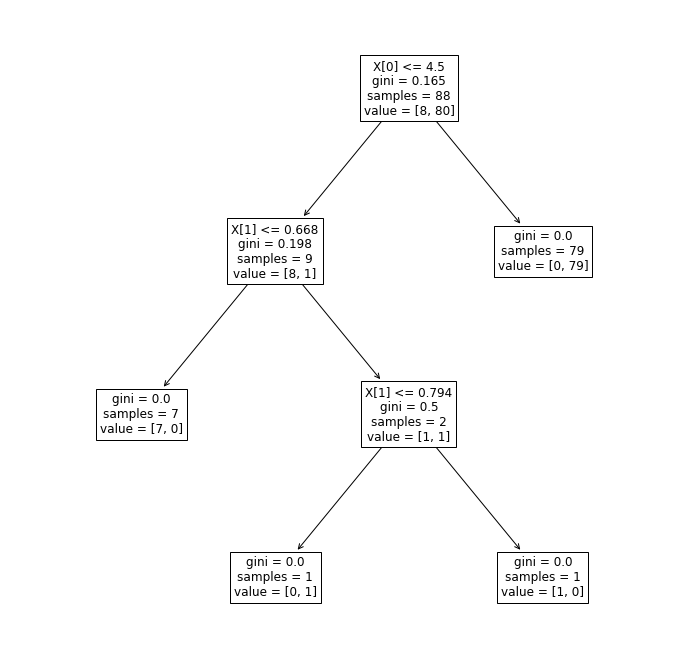

In [39]:
plt.figure(figsize=(12,12))
tree.plot_tree(clf,fontsize=12)

When seasons aren't present and other factors are held constant, we see that the dominant factor is the gamma. Small values of gamma lead to more multicellularity, due to better agreement between ligands and receptors. 

# 2. Identify correlations between initial and final multicellularity

In [40]:
Y_initial = num_blob_data[:,0].reshape(len(num_blob_data))
Y_final = num_blob_data[:,-1].reshape(len(num_blob_data))

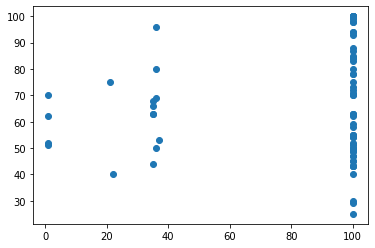

In [41]:
plt.scatter(Y_initial,Y_final)

In [42]:
np.corrcoef(Y_initial,Y_final)

array([[1.        , 0.09281665],
       [0.09281665, 1.        ]])

(array([ 4.,  0.,  2., 10.,  0.,  0.,  0.,  0.,  0., 59.]),
 array([  1. ,  10.9,  20.8,  30.7,  40.6,  50.5,  60.4,  70.3,  80.2,
         90.1, 100. ]),
 <BarContainer object of 10 artists>)

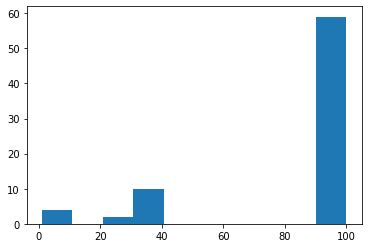

In [43]:
plt.hist(Y_initial)

(0.0, 60.0)

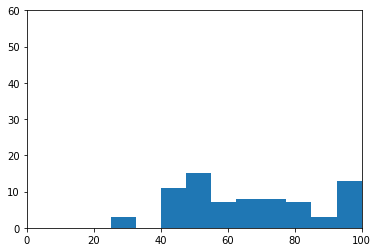

In [44]:
plt.hist(Y_final)
plt.xlim([0,100])
plt.ylim([0,60])

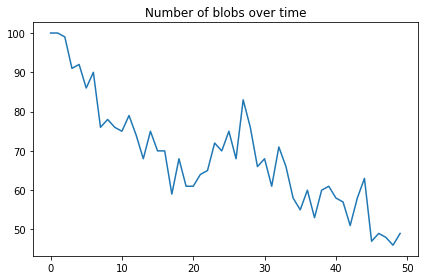

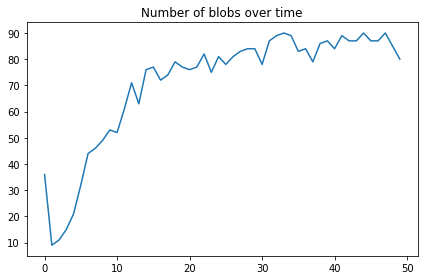

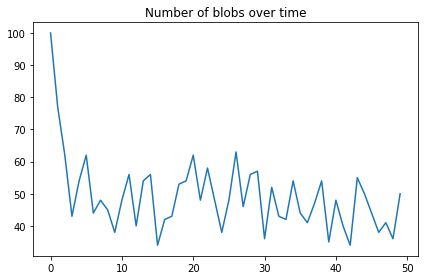

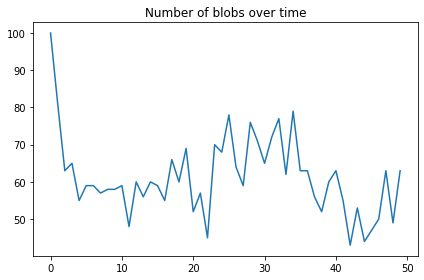

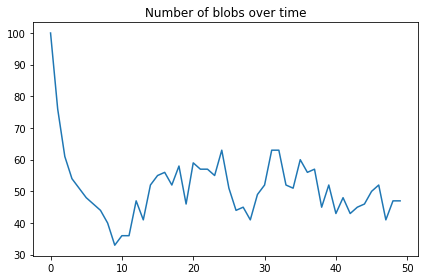

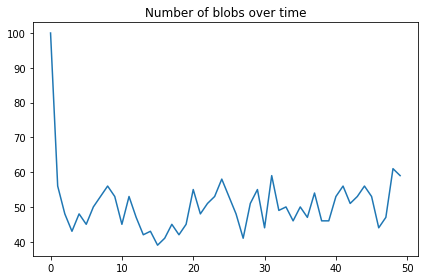

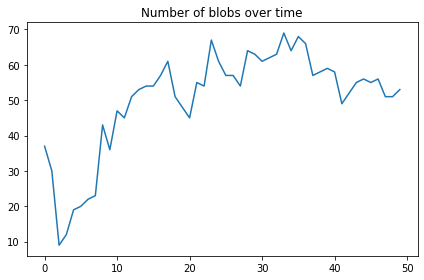

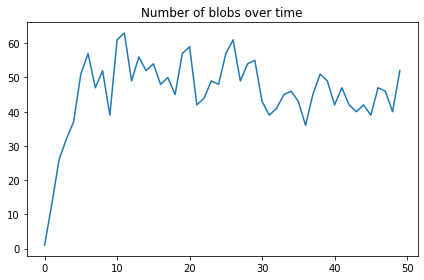

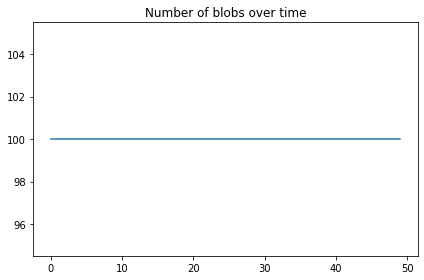

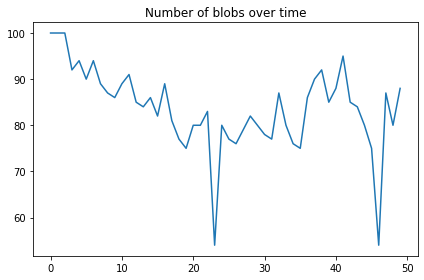

<Figure size 432x288 with 0 Axes>

In [45]:
for i in range(10):
    plt.title("Number of blobs over time")
    index = random.randint(0,len(num_blob_data)-1)
    plt.plot(list(range(len(num_blob_data[index]))),num_blob_data[index])
    plt.tight_layout()
    plt.figure()

(array([ 3., 17., 12.,  9.,  9., 10.,  3.,  5.,  4.,  3.]),
 array([-75. , -60.6, -46.2, -31.8, -17.4,  -3. ,  11.4,  25.8,  40.2,
         54.6,  69. ]),
 <BarContainer object of 10 artists>)

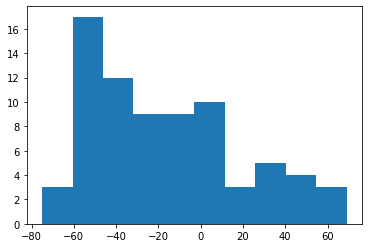

In [52]:
plt.hist(num_blob_data[:,-1]-num_blob_data[:,0])

(array([ 1.,  2., 78.,  2.,  0.,  0.,  1.,  0.,  1.,  3.]),
 array([-23. , -14.2,  -5.4,   3.4,  12.2,  21. ,  29.8,  38.6,  47.4,
         56.2,  65. ]),
 <BarContainer object of 10 artists>)

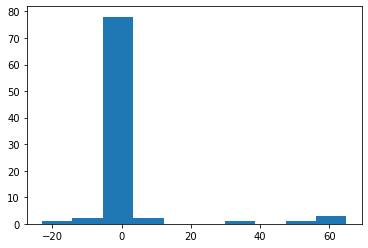

In [53]:
plt.hist(num_blob_data_small[:,-1]-num_blob_data_small[:,0])

We see that initial settings are not soley responsible for the propogation of multicellularity. For different simulations which start with 100 blobs (all cells indepdent), we see that, depending on the celllar and environmental conditions, they tend to break off into different strata. Some simulations start with a sharp increase in multicellularity, followed by a levelling off, while others tend to remain unicellular throughout. In general, many simulations tend towards a degree of multicellularity, which is seen through the two histograms

Finally, we notice that seasonality is a big reason why multicellularity changes over time; in the Latin Gradient simulation, it's clear that there's less of a change in the nubmer of blobs when compared with the full dataset. 

# 3. Train a GP to predict final multicellularity on Latin Gradient Data

In [299]:
kernel = GPy.kern.RBF(input_dim=X_small.shape[-1])
Y_final = num_blob_data_small[:,-1]
model_gpy = GPRegression(X_small, Y_final.reshape((len(Y_final),1)),normalizer=True)
model_emukit = GPyModelWrapper(model_gpy)
model_gpy.optimize()
model_emukit.optimize()

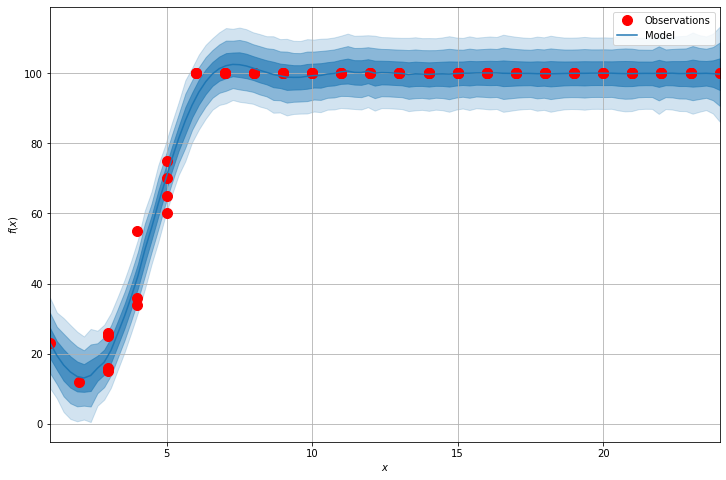

In [300]:
plot_gaussian_process(0,parameter_space_small,model_emukit)

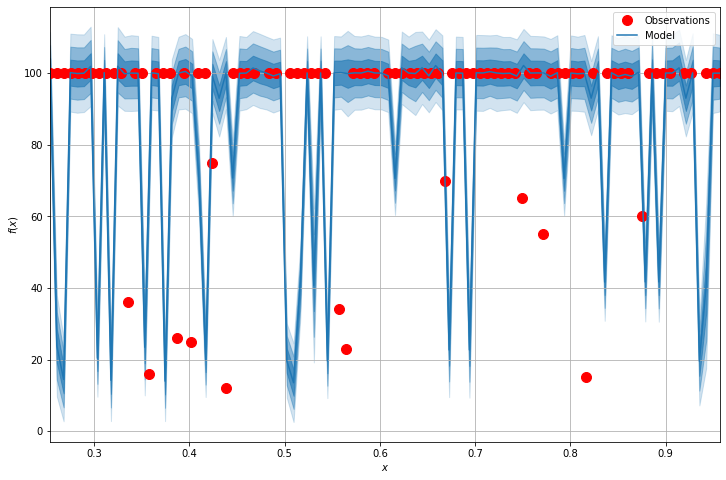

In [301]:
plot_gaussian_process(1,parameter_space_small,model_emukit)

Text(0.5, 0.92, 'Predicted angle difference between chemotaxis vector and ground truth gradient position based on gamma and gradient noise')

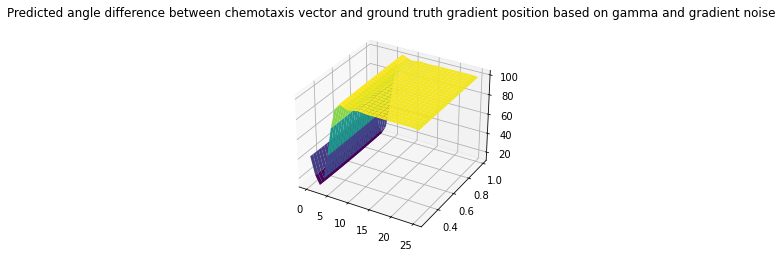

In [302]:
_gamma_test = np.linspace(0, 25, 25)
_gradnoise_test = np.linspace(0.25, 0.99, 25)

coords_gamma, coords_gradnoise = np.meshgrid(_gamma_test, _gradnoise_test)

_mean, _var = model_emukit.predict(np.c_[coords_gamma.ravel(), coords_gradnoise.ravel()])

reshaped_mean = _mean.reshape(coords_gamma.shape)


ax = plt.axes(projection='3d')
ax.plot_surface(coords_gamma, coords_gradnoise, reshaped_mean, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Predicted angle difference between chemotaxis vector and ground truth gradient position based on gamma and gradient noise')
# ax.scatter(model_emukit.X[0][0], model_emukit.X[0][1], model_emukit.Y[0], color='red', s=300, marker='x')

In [304]:
get_sobol_indices(model_emukit,parameter_space_small)

({'gamma': array([1.00075921]), 'gradnoise': array([0.06132845])},
 {'gamma': array([0.93846254]), 'gradnoise': array([-0.06087068])})

From this it's clear that the gamma parameter dominates over the grad noise parameter, and that low values of gamma are responsible for cells tending to form less blobs. 

# 4. Run Bayesian Optimization to find Optimal Temperature

## 4a. Optimal Temperature when gamma is low

In [470]:
def is_running():
    string='ps -e | grep "cell_evolution"'
    result=subprocess.getoutput(string)
    return len(result)>5


In [471]:
starting_number = 0

In [472]:
def f(X):
    global starting_number
        
    identifier = starting_number
    X = np.array(X)
        
    for i in range(X.shape[0]):
        new_parameters = deepcopy(const_parameters)
        
        for j,name in enumerate(parameter_list):
            new_parameters[name] = data_types[name](X[i][j])
            
        config_file = "latin_{}.par".format(identifier)
        
        create_config(config_file,new_parameters)
                
        execute_experiment(config_file,identifier)
        identifier = identifier+1
                    
    starting_number += X.shape[0]
            
    while is_running():
        time.sleep(5)
    
        
    Y = get_rewards(["data_cellcount_{}.txt".format(i) for i in range(identifier,identifier+X.shape[0])],lambda s: average_function_over_time(num_blobs_cells)(s))
    
    return Y

In [473]:
def f_opt(X):
    X = np.array(X).reshape((len(X)),1)
    return float(f(X)[0,0])

In [474]:
data_types = {
    'season_duration': int,
    'T': float, 
    'gamma': int, 
    'gradnoise': float, 
    'target_area': int, 
    'mut_rate': float, 
}

In [475]:
const_parameters = {
    'mcs': 10000, 
    'gamma': 4, 
    'gradnoise': 0.9, 
    'target_area': 50, 
    'mut_rate': 0,
    'season_duration': 250, 
    'evolsim': 0,
}

In [476]:
parameter_list = ['T']
parameter_space = ParameterSpace([ContinuousParameter('T',1,100)])

In [477]:
res = gp_minimize(f_opt,                  # the function to minimize
                  [(0,100)],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=10,         # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                 )   


 /home/nraman1/.local/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:The objective has been evaluated at this point before.


In [478]:
res.x_iters

[[93], [74], [75], [27], [12], [93], [92], [94], [29], [26]]

In [479]:
X = res.x_iters
Y = res.func_vals
X = np.array(X).reshape(len(X),1)
Y = np.array(Y).reshape(len(Y),1)

In [480]:
kernel = GPy.kern.RBF(input_dim=X.shape[-1])
model_gpy = GPRegression(X,Y,kernel=kernel,normalizer=True)
model_emukit = GPyModelWrapper(model_gpy)
model_gpy.optimize()
model_emukit.optimize()

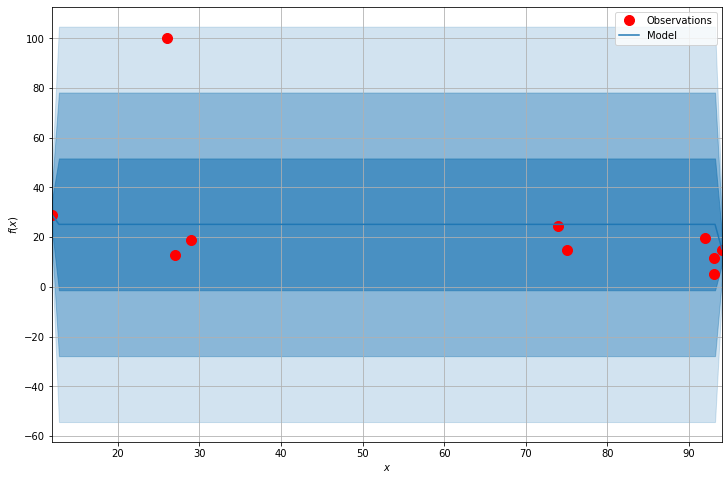

In [481]:
plot_gaussian_process(0,parameter_space,model_emukit)

In [482]:
model_sklearn = GaussianProcessRegressor().fit(X,Y)
model_emukit = SklearnGPModel(model_sklearn)
model_emukit.optimize()

In [483]:
mean_predictions_gpr, std_predictions_gpr = model_emukit.predict(
    np.linspace(X.min(),X.max(),50).reshape(-1,1))

 /home/nraman1/.local/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning:Predicted variances smaller than 0. Setting those variances to 0.


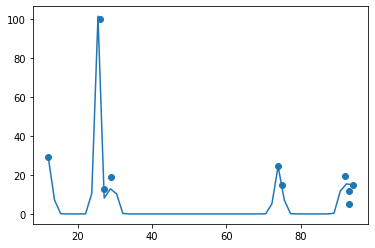

In [484]:
plt.scatter(X,Y)
plt.plot(np.linspace(X.min(),X.max(),50).flatten(),mean_predictions_gpr.flatten())

 /home/nraman1/.local/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning:Predicted variances smaller than 0. Setting those variances to 0.


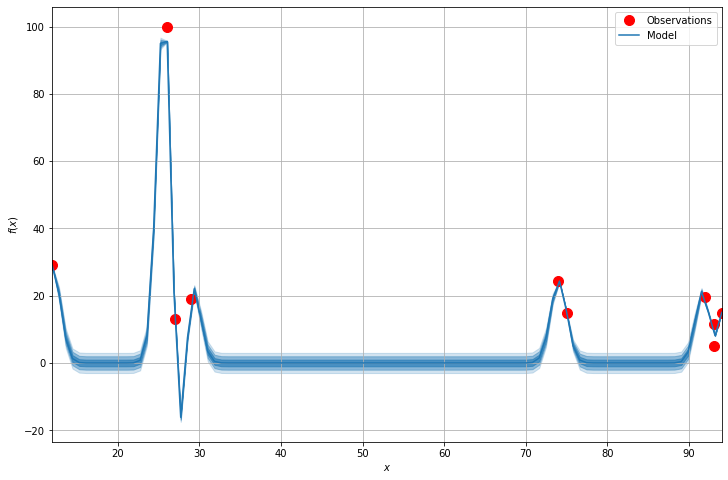

In [485]:
plot_gaussian_process(0,parameter_space,model_emukit)

### Part 2, Trying to maximize the number of clusters

In [486]:
def f_opt(X):
    print(X)
    X = np.array(X).reshape((len(X)),1)
    return 100-float(f(X)[0,0])

In [487]:
starting_number = 0

In [488]:
const_parameters = {
    'mcs': 10000, 
    'gamma': 4, 
    'gradnoise': 0.9, 
    'target_area': 50, 
    'mut_rate': 0,
    'season_duration': 250, 
    'evolsim': 0,
}

In [495]:
res = gp_minimize(f_opt,                  # the function to minimize
                  [(0,100)],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=10,         # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                 )   


[27]
[87]
[35]
[62]
[28]


 /home/nraman1/.local/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:The objective has been evaluated at this point before.


[62]


 /home/nraman1/.local/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:The objective has been evaluated at this point before.


[35]


 /home/nraman1/.local/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:The objective has been evaluated at this point before.


[87]
[0]
[26]


In [496]:
res.x_iters

[[27], [87], [35], [62], [28], [62], [35], [87], [0], [26]]

In [497]:
X = res.x_iters
Y = res.func_vals
X = np.array(X).reshape(len(X),1)
Y = np.array(Y).reshape(len(Y),1)

In [498]:
kernel = GPy.kern.RBF(input_dim=X.shape[-1])
model_gpy = GPRegression(X,Y,kernel=kernel,normalizer=True)
model_emukit = GPyModelWrapper(model_gpy)
model_gpy.optimize()
model_emukit.optimize()

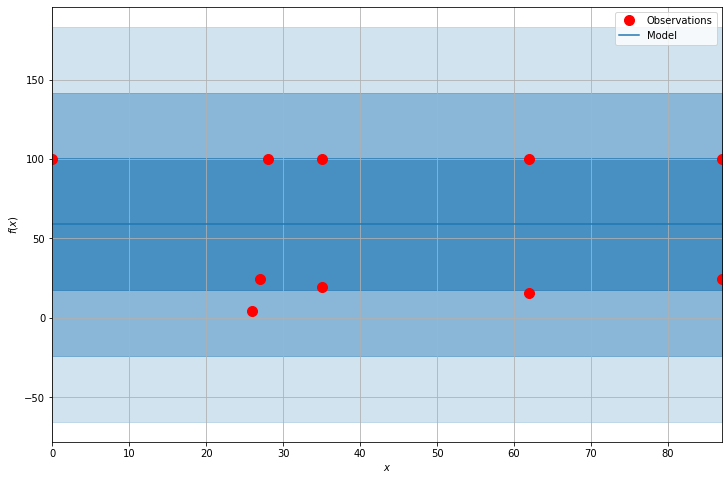

In [499]:
plot_gaussian_process(0,parameter_space,model_emukit)

In [500]:
model_sklearn = GaussianProcessRegressor().fit(X,Y)
model_emukit = SklearnGPModel(model_sklearn)
model_emukit.optimize()

In [501]:
mean_predictions_gpr, std_predictions_gpr = model_emukit.predict(
    np.linspace(X.min(),X.max(),50).reshape(-1,1))

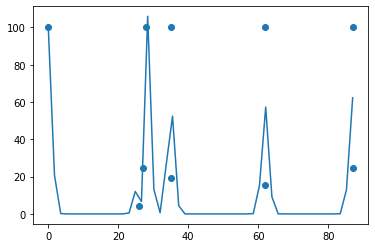

In [502]:
plt.scatter(X,Y)
plt.plot(np.linspace(X.min(),X.max(),50).flatten(),mean_predictions_gpr.flatten())

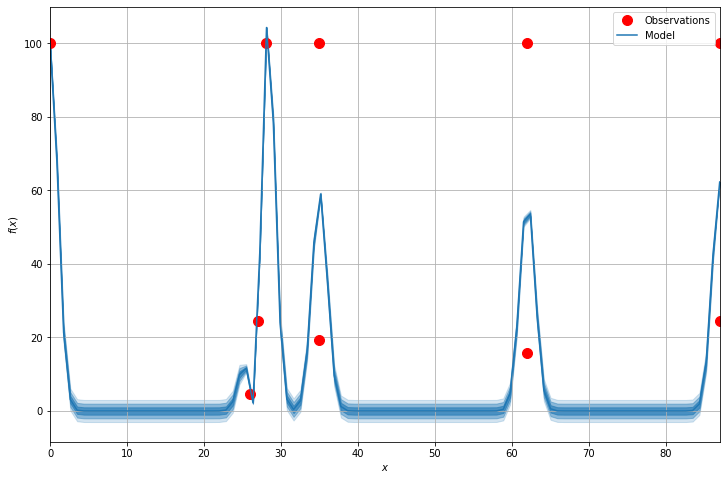

In [503]:
plot_gaussian_process(0,parameter_space,model_emukit)

## 4b. Optimal Temperature when Gamma is high

In [504]:
def f_opt(X):
    print(X)
    X = np.array(X).reshape((len(X)),1)
    return float(f(X)[0,0])

In [505]:
starting_number = 0

In [506]:
const_parameters = {
    'mcs': 10000, 
    'gamma': 12, 
    'gradnoise': 0.9, 
    'target_area': 50, 
    'mut_rate': 0,
    'season_duration': 250, 
    'evolsim': 0,
}

In [507]:
num_data_points = 5
design = RandomDesign(parameter_space) # Collect random points
X = design.get_samples(num_data_points)

In [508]:
Y = f(X)

In [509]:
X, Y

(array([[13.16858461],
        [ 6.40590172],
        [41.41845518],
        [75.32953306],
        [21.14618639]]),
 array([[100.],
        [100.],
        [100.],
        [100.],
        [100.]]))

In [510]:
res = gp_minimize(f_opt,                  # the function to minimize
                  [(0,100)],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=10,         # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                 )   


[86]
[29]
[57]
[88]
[20]


ValueError: array must not contain infs or NaNs

In [511]:
res.x_iters

[[27], [87], [35], [62], [28], [62], [35], [87], [0], [26]]

In [512]:
X = res.x_iters
Y = res.func_vals
X = np.array(X).reshape(len(X),1)
Y = np.array(Y).reshape(len(Y),1)

In [513]:
kernel = GPy.kern.RBF(input_dim=X.shape[-1])
model_gpy = GPRegression(X,Y,kernel=kernel,normalizer=True)
model_emukit = GPyModelWrapper(model_gpy)
model_gpy.optimize()
model_emukit.optimize()

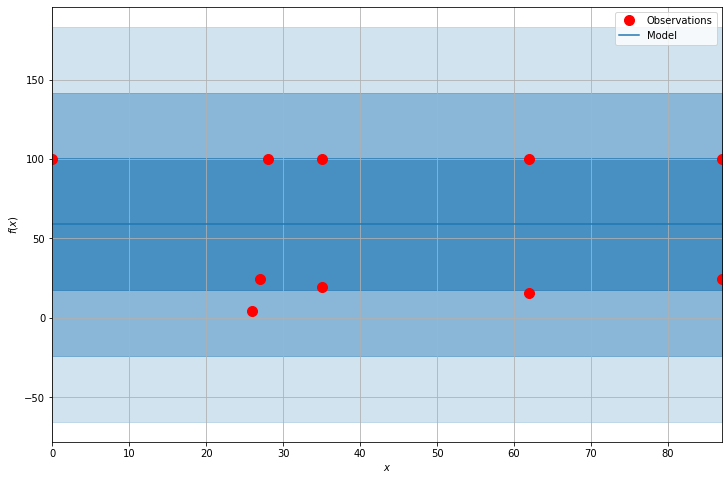

In [514]:
plot_gaussian_process(0,parameter_space,model_emukit)

In [515]:
model_sklearn = GaussianProcessRegressor().fit(X,Y)
model_emukit = SklearnGPModel(model_sklearn)
model_emukit.optimize()

In [516]:
mean_predictions_gpr, std_predictions_gpr = model_emukit.predict(
    np.linspace(X.min(),X.max(),50).reshape(-1,1))

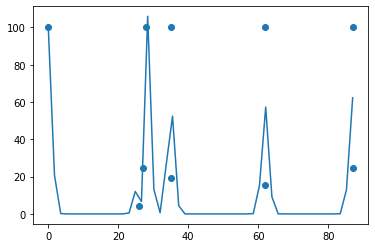

In [517]:
plt.scatter(X,Y)
plt.plot(np.linspace(X.min(),X.max(),50).flatten(),mean_predictions_gpr.flatten())

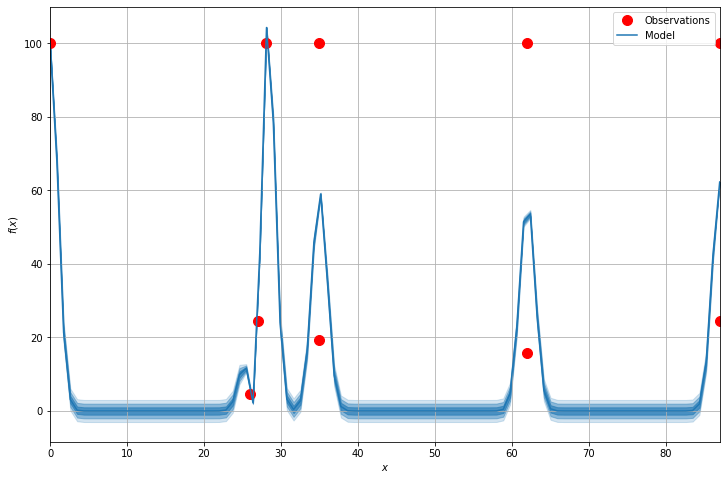

In [518]:
plot_gaussian_process(0,parameter_space,model_emukit)